In [1]:
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LSQUnivariateSpline
from scipy.stats import norm, expon, rdist

from cdf_est_CVXOPT import *

# Overview
- **objective**: want to implement a tool for generating a smooth estimate of a distribution $\mathbb{X}$'s probability distribution function (pdf) from a set of $n$ samples, $\vec{X} = [X_i$ for $i\in[0,n)]$

# Methodology

## Likelihood Functions
- first, let $\sigma$ be a function that orders the sample values, such that
    $X_{\sigma(i)} \leq X_{\sigma(i+1)} \forall i$
- then for each $i$, consider the probability that the distribution $\mathbb{X}$ will be less than this value, $p_i := P\left(\mathbb{X} < X_{\sigma(i)}\right)$
- since exactly $i+\frac12$ samples subceed $X_{\sigma(i)}$, we can evaluate the **likelihood** of this probability
    - (this includes the first $i$ samples $X_{\sigma(j)}$ for $j<i$,
        and half-counts $X_{\sigma(i)}$ which has an exact value)
    - $\mathcal{L}\left(p_i=p \ \ \left| \ \ \vec{X}\right.\right) := {(p)}^{i+\frac12}{(1-p)}^{n-i-\frac12}$
- $\rightarrow$ a good estimate will *maximize* this likelihood
    - while a solution could simply interpolate a monotonic spline through the pairs of values,
        $\left(X_{\sigma(i)}, \hat{p}_i = \frac{i+0.5}{n}\right)$ for all $i$,
        this would likely create an unstably fluctuating result (due to the random nature of the samples)
        that would stray from any likeness of the original distribution.
        Thus, it is also important to ensure a level of *smoothness* in the resulting estimate,
        which will be discussed later.

## Approximation of Likelihood Function
- The above likelihood is well approximated (for near-optimal $p$-values and large $n$) by
    a **second-degree polynomial** (see the graph generated below)
- $\rightarrow \mathcal{L}\left(p_i=p \ \ \left| \ \ \vec{X}\right.\right)
    \div \mathcal{L}\left(\hat{p}_i...\right)
    \sim 1 - c {\left(\hat{p}_i - p\right)}^2$, where:
    - the value $c$ is proportional to the *second derivative* of the likelihood function,
        $c := -\frac12\frac{d^2}{dp^2} \mathcal{L}(...) > 0$
    - $\hat{p}_i$ is the most likely probability for a given $i$;
        specifically, $\hat{p}_i = \frac{i+0.5}{n}$

/home/chrx/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


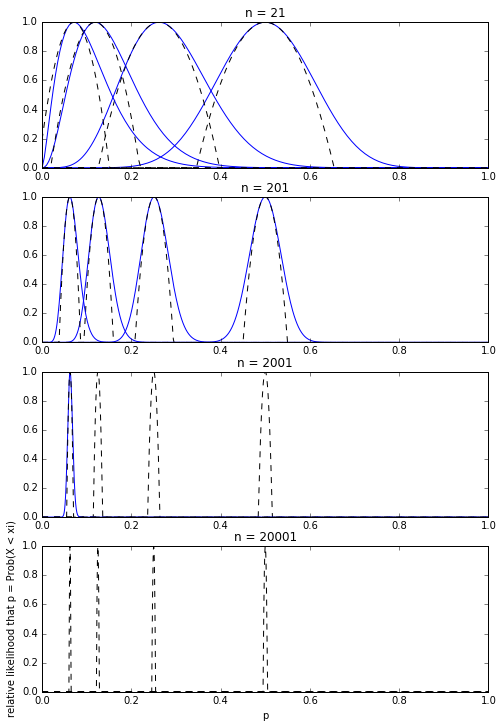

In [2]:
def plot_lhood(n,k):
    """
    Plots the relative likelihood function for n and k, and a quadratic estimate
    centered on the maximum likelihood value.

    Args:
        n: the number of samples from the random variable, X
        k: the hierarchical position of the sample when ordered
            k in [0,n)
    Returns:
        None
    Raises:
        N/A
    """
    p_samples = np.linspace(0,1,max(3*n,200))
    # Plot relative likelihood for the k-th sample of n samples
    plt.plot(p_samples, lhood(n,k,p_samples) / lhood(n,k), 'b')

    # Plot quadratic local estimate of relative likelihood
    rlhood_loc_samples = 1 + .5 * d2dp2_rlhood(n,k) * (p_samples-p_maxlh(n,k))**2
    rlhood_loc_samples[rlhood_loc_samples<0] = 0
    plt.plot(p_samples, rlhood_loc_samples, 'k--')


def demo_lhood_quadapprox():
    """
    Plots the likelihoods, Lk := [P(x < Xk) == p], for various values of n and k.

    Conclusion: the likelihood function, near the max-l value, is well-approximated
        by a 2nd-degree polynomial (i.e., quadratic) centered at the max-l value
    """
    plt.figure(figsize=(8,12))

    sample_sizes = (21,) + (201,) + (2001,) + (20001,)
    for plot_no, sample_count in enumerate(sample_sizes,1):
        plt.subplot(len(sample_sizes), 1, plot_no)
        plt.title("n = " + str(sample_count))
        for i in range(1,5):
            plot_lhood(sample_count, (sample_count >> i))

    plt.xlabel("p")
    plt.ylabel("relative likelihood that p = Prob(X < xi)")
    plt.show()

demo_lhood_quadapprox()

## Smoothness
- smoothness can be loosely measured by *the magnitude of the higher-order derivatives* of the cdf estimate
    - lesser magnitudes $\rightarrow$ more smooth
    - greater magnitudes $\rightarrow$ less smooth
- $\rightarrow$ a good estimate will **minimize higher-order derivatives**    

## Balancing Likelihood vs Smoothness

The objective function
    $\approx s\int_{X_{\sigma(0)}}^{X_{\sigma(n-1)}} d(x) dx
    \ \ +\ \  t\sum_{i=0}^{n-1} c {\left(\hat{p}_i - p\right)}^2$
- $d(x)$ is the $m$th derivative of the estimate cdf
- $s$, $t$ are constants that affect how the overall error is calculated as a result of
    the smoothness and likelihood of the cdf estimate, respectively
- $s$ and $t$ may be functions of $n$ or $\vec{X}$


**Goal** - need to intellignetly choose $s, t$ values to balance maximizing likelihood vs smoothness

- the cdf estimate calculation should be **immune to stretching** of the random variable $\mathbb{X}$
    - for example: the estimate for $2\mathbb{X}$ should simply be
        a stretched version of the estimate for $\mathbb{X}$
    - $\rightarrow s\left(\vec{X}\right) \propto \frac{1}{X_{\sigma(n-1)} - X_{\sigma(0)}}$
- the estimate should smooth the curve around a sequential subset of $m$ sample points
    **by a relatively constant amount**, regardless of the total number of samples $n$,
    or the range across which those samples span
    - $\rightarrow s(n) \propto 1$
        - the $\hat{p}_i$ values for $m$ of $n$ samples span a range of $\approx \frac{m}{n}$
            - $d$-value significance increases by a factor of $n$
        - the domain breadth of the $m$ samples will likely also be proportional to $\frac1n$
            (more samples, higher density, smaller range in which $m$ values sit)
            - $d$-value significance decreases by a factor of $n$
    - $\rightarrow t(n) \propto \frac1{n\log(n)}$
        - the sum of all $n$ $\frac{d^2}{dp^2} \mathcal{L}(...)$ values trends to $n^2\log(n)$
        (see plot below)
        - a sub-sum of $m$ of these values is, on average, $\propto n\log(n)$ 
        - this should be scaled to a relative constant, to be independent of $n$

$\Rightarrow \frac{t}{s} \propto \frac{X_{\sigma(n-1)} - X_{\sigma(0)}}{n\log(n)}$

### Trend: Average $\frac{d^2}{dp^2}$-Likelihood vs. $n$

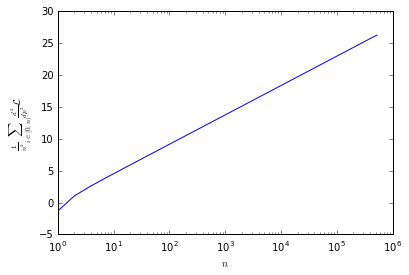

In [3]:
def demo_trend_lhood_sum():
    """
    Plots on a log plot the scaled sum of relative likelihoods,
    Lrel_k := Lk(p) / Lk(phat_k).

    Conclusion: the sum of relative likelihoods trends like n^2 log(n)
    """
    _n = 2**np.arange(20)
    lsums = np.array([
        -np.sum(d2dp2_rlhood(n,np.arange(1,n+1))) / (n ** 2)
        for n in _n])
    plt.plot(_n, lsums)
    
    plt.xscale("log")
    plt.xlabel("$n$")
    plt.ylabel("$\\frac{1}{n^2}\\sum_{i\\in[0,n)}\\frac{d^2}{dp^2}\\mathcal{L}$")
    
    plt.show()    # plot is affine (on log scale)

demo_trend_lhood_sum()

$\rightarrow \sum_{i\in[0,n)}\frac{d^2}{dp^2}\mathcal{L}
    \propto n^2\log(n)$

# Implementation
- choose to characterize "smoothness" as the *second derivative*
    - can then frame problem as a quadratic programming problem
    - optimize using a QP-solver

rms error (Normal Distribution,n=11): 0.0010583738308897195
rms error (Normal Distribution,n=31): 0.0003617496005530131
rms error (Normal Distribution,n=101): 0.0001955092550021825
rms error (Normal Distribution,n=201): 0.0001908192583939069


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


rms error (Exponential Distribution,n=11): 0.0006948531863368976
rms error (Exponential Distribution,n=31): 0.0003348138337712562
rms error (Exponential Distribution,n=101): 0.0003236862250918801
rms error (Exponential Distribution,n=201): 0.0002796786312344115
rms error (RDist,n=11): 0.0011673089133038075
rms error (RDist,n=31): 0.0011664491892002383
rms error (RDist,n=101): 0.00109104562690689
rms error (RDist,n=201): 0.0010024234042428238


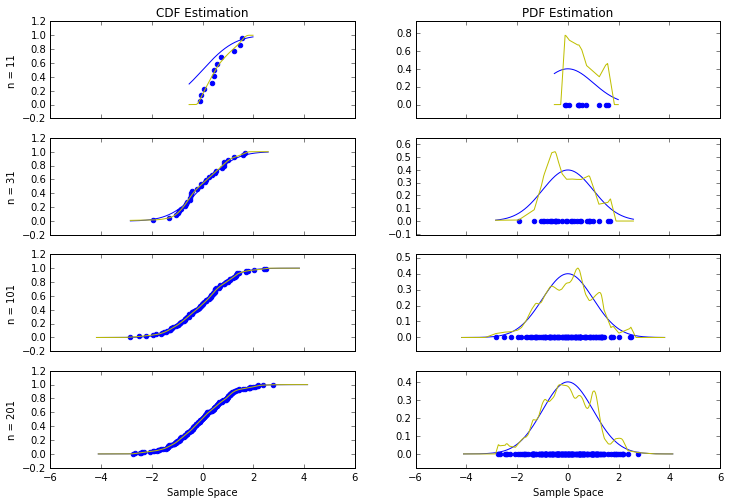

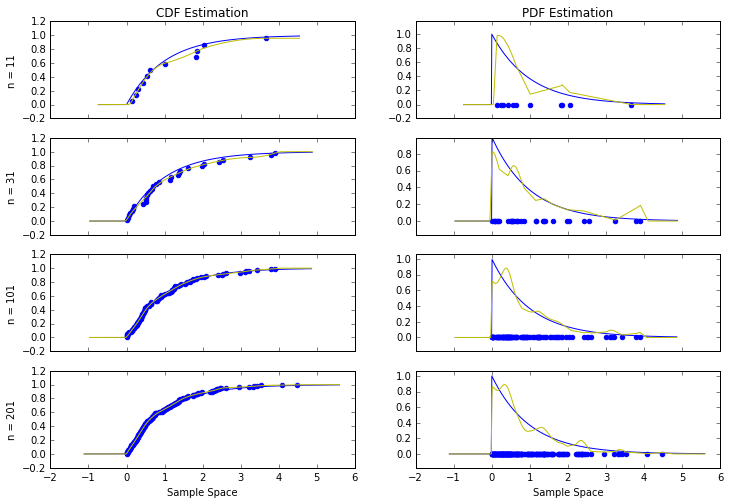

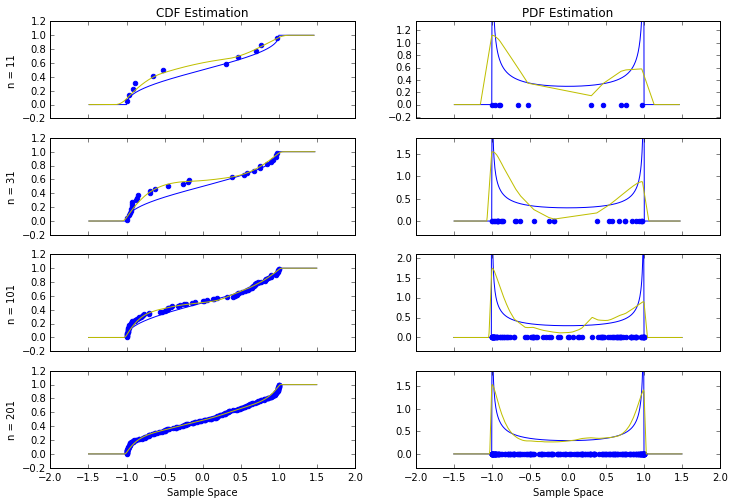

In [4]:
def cdf_est_error(cdf, cdf_est):
    lower_bound = cdf.ppf(0.005)
    upper_bound = cdf.ppf(0.995)
    
    X_samples = np.linspace(lower_bound, upper_bound, 1000)
    return np.sqrt(np.mean((
        np.diff(cdf.cdf(X_samples)) - np.diff(cdf_est(X_samples))
        )**2 ))

def bounds_w_margin(bounds, margin=0.2):
    breadth = bounds[1] - bounds[0]
    return (bounds[0] - margin*breadth, bounds[1] + margin*breadth)

def test_plot_cdf_approx():
    color_true, style_true = '#0000FF', '-'
    color_est, style_est = 'y', '-'
    sample_sizes = (11, 31, 101, 201) #+ (2001,) + (20001,)
    
    vars = (norm(), expon(), rdist(0.9))
    var_names = (
        "Normal Distribution",
        "Exponential Distribution",
        "RDist",
    )
    
    for var, var_name in zip(vars, var_names):
        
        fig, axes = plt.subplots(len(sample_sizes), 2, sharex=True, figsize=(12,8))
        fig.canvas.set_window_title(var_name)
        
        for plot_no, sample_count in enumerate(sample_sizes):
            
            axes[plot_no, 0].set_ylabel("n = " + str(sample_count))
            
            X = var.rvs(size=sample_count)
            X.sort()
            X_plotpoints = np.linspace(
                X[0] - 0.25*(X[-1]-X[0]),
                X[-1] + 0.25*(X[-1]-X[0]),
                500
            )
            
            X_cdf = cdf_approx(X)
            axes[plot_no, 0].scatter(
                X, np.arange(1,2*sample_count,2) / (2*sample_count),
                color=color_true)
            axes[plot_no, 0].plot(X_plotpoints, var.cdf(X_plotpoints), color_true)
            axes[plot_no, 0].plot(X_plotpoints, X_cdf(X_plotpoints), color_est)
            
            X_pdf = X_cdf.derivative()
            axes[plot_no, 1].scatter(X, np.zeros_like(X), color=color_true)
            axes[plot_no, 1].plot(X_plotpoints, var.pdf(X_plotpoints), color_true)
            axes[plot_no, 1].plot(X_plotpoints, X_pdf(X_plotpoints), color_est)
            axes[plot_no, 1].set_ylim(bounds_w_margin((
                min(X_pdf(X_plotpoints)),
                max(X_pdf(X_plotpoints))
            )))
            
            print("rms error (" + ','.join([var_name, "n="+str(sample_count)]) + "):",
                  cdf_est_error(var, X_cdf))
        
        axes[0,0].set_title("CDF Estimation")
        axes[0,1].set_title("PDF Estimation")
        axes[-1, 0].set_xlabel("Sample Space")
        axes[-1, 1].set_xlabel("Sample Space")
        
        fig.show()

test_plot_cdf_approx()

# TODO
- errors
    - occasionally get a `ValueError` - "x values are not in order"
        - maybe optimizer results are not in (0,1) interval?
    - occasionally get a `ArithmeticError` from solver
        - error codes observed: 93, 102, 195, 202
        - ...?
    - crashes with `MemoryError` for $n > \sim 200$
- poor behavior
    - on `rdist` plot, curve does a poor job of tracing `X` samples for larger `n`
        (once in a while, it generates a horizontal line at Prob=$\frac12$)
        - maybe optimizer stops short of a "good answer"?
        - maybe scaling isn't properly characterized,
            and "smoothness" becomes too highly prioritized for larger `n`?
    - need to test for larger sample sizes to demonstrate proper characterization
        of smoothness vs likelihood scaling
- visuals
    - calculate error in pdf estimation
- theories
    - should take a second look at the smoothness vs. likelihood scaling characterizations
        (just a hunch)